## Social capital

There are currently 2 faces of the same coin: 
- Complexity economics points to the fact that the trade network topology has an effect on GDP, inequality, etc (they look at the bipartite network of countries products)
- Jackson theoretically argues that there is another type of capital called \textit{social capital}. This social capital is related to network centrality. [https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3073496]

**Hypothesis:** social capital captures topological information about the trade network, something that the index of economic complexity is doing at the end of the day. 


Classical Cobb-Douglass production functions in macroeconomics 

$$GDP = A\cdot K^{\alpha} \cdot L^{\beta}$$

or 

$$\log(GDP) = \log(A) + \alpha\cdot\log(K)  + \beta\cdot\log(L)$$

With our trade and migration networks we can include the social capital measures of centrality

$$\log(GDP) = \log(A) + \alpha\cdot\log(K)  + \beta\cdot\log(L) + \gamma_1\cdot\log(social capital (financial)) + \gamma_2\cdot\log(social capital (human))$$

### Types of capital
- Information capital: decay centrality --> when $T\rightarrow\infty$ eigenvector centrality --> pagerank for weighted directed graph 
- Brokerage, Coordination, and Leadership Capital --> Godfather index
- Bridging Capital --> not implemented
- Favor Capital and Support --> *counting the number of friends that a person has who are supported by a friend in common* (not implemented)

### Findings so far
- Social capital (both financial and human) is significantly related to a country's GDP
- Both information and Brokerage-Coordination-Leadership Capital are relevant
- The delta of this magnitudes from year to year also explains the delta in GDP

### TODOs:
- Classical production function. What is the present model?
- What is that we need to add to the current model? --> social capital (not included in financial capital)
- Extra Jackson social capital measures (Bridging + favor capital)
- Industry network
- Time series analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

import numpy as np

import patsy
import statsmodels.api as sm
from linearmodels import PanelOLS
from linearmodels import RandomEffects
from linearmodels.panel import BetweenOLS, PooledOLS, compare

from linearmodels import IV2SLS

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df_model = pd.read_parquet('data_model.parquet')
centralities = ['pagerank', 'gfi', 'bridging', 'favor']

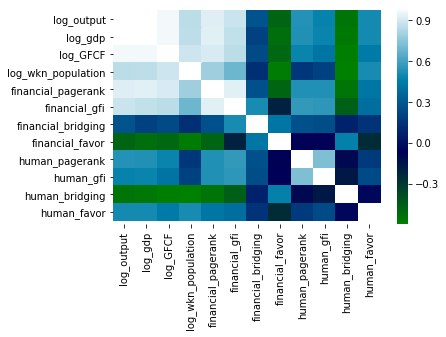

In [4]:
corr_cols = ['log_output', 'log_gdp', 'log_GFCF', 'log_wkn_population'] + ['financial_' + c for c in centralities] + ['human_' + c for c in centralities]

corr = df_model[corr_cols].corr()

# plot the heatmap
sns.heatmap(corr, cmap="ocean",
        xticklabels=corr.columns,
        yticklabels=corr.columns,)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.7 # Add 0.5 to the bottom
t -= 0.7 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

In [ ]:
sns.pairplot(df_model[corr_cols])

## Simultaneous model capital and migration

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)

df_model['financial_pca'] = pca.fit_transform(df_model[['financial_' + c for c in centralities]])
print(pca.explained_variance_ratio_)

df_model['human_pca'] = pca.fit_transform(df_model[['human_' + c for c in centralities]])
print(pca.explained_variance_ratio_)

In [ ]:
f = 'log_gdp ~ financial_pca + human_pca + log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')

model = RandomEffects(y,X)
results = model.fit()
results.summary

In [ ]:
all_terms_list = ['financial_' + c for c in centralities] + ['human_' + c for c in centralities]
all_terms = ' + '.join(all_terms_list)

f = f'log_gdp ~ {all_terms} + log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
model = RandomEffects(y,X)
results_combined_model = model.fit()

df_results = pd.DataFrame(results_combined_model.params).reset_index()
df_results['pvalues'] = results_combined_model.pvalues.values
df_results['show_value'] = df_results.apply(lambda x: f'{round(x.parameter,4)} ({round(x.pvalues, 5)})', axis=1)
df_results = df_results[~df_results['index'].isin(['Intercept','log_GFCF','log_wkn_population'])]
df_results['network'], df_results['capital'] = zip(*df_results['index'].map(lambda x: (x.split('_')[0], x.split('_')[1])))
df_results.pivot_table(index='network', columns = 'capital', values = 'show_value', aggfunc=np.unique)

In [ ]:
all_results = []
for c in centralities: 

    f = f'log_gdp ~ financial_{c} + human_{c} + log_GFCF + log_wkn_population + 1'
    y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
    model = RandomEffects(y,X)
    all_results.append(model.fit())


all_terms_list = ['financial_' + c for c in centralities] + ['human_' + c for c in centralities]
all_terms = ' + '.join(all_terms_list)

f = f'log_gdp ~ {all_terms} + log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
model = RandomEffects(y,X)
results_combined_model = model.fit()

all_models = dict(zip(centralities, all_results))
all_models['all'] = results_combined_model

compare(all_models)

In [ ]:
f = f'log_gdp ~ {all_terms} + log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')

be_res = BetweenOLS(y,X)
be_res = model.fit()

model = PooledOLS(y,X)
pooled_res = model.fit()

model = RandomEffects(y,X)
re_res = model.fit()

compare({'BE':be_res,'RE':re_res,'Pooled':pooled_res})

## Growth prediction

In [ ]:
from pandas.plotting import autocorrelation_plot
df_country = df_model[df_model.country == 'ARG']
autocorrelation_plot(df_country.log_output)

In [ ]:
f = 'delta_log_output ~ lag_financial_pagerank + lag_human_gfi + lag_log_output  + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')

model = RandomEffects(y,X)
results = model.fit()
results.summary

In [ ]:
model = IV2SLS(df_model.delta_log_output, df_model[['delta_financial_gfi', 'delta_human_gfi', 'constant']], df_model.lag_log_output, df_model.lag_log2_output)
results = model.fit()
results.summary